# Ada Boost

In [8]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data, evaluate_metrics, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data(df)

We will begin with an untuned model.

In [4]:
ada_untuned = AdaBoostClassifier(random_state=2025)
ada_untuned.fit(X_train, y_train)

,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,2025


In [5]:
y_train_pred = ada_untuned.predict(X_train)
y_test_pred = ada_untuned.predict(X_test)

Training Set Metrics:


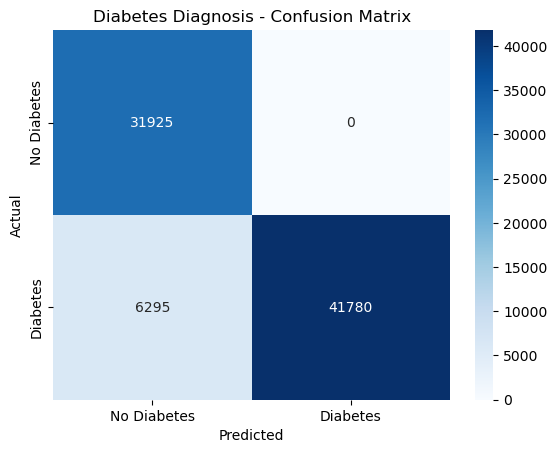

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics:


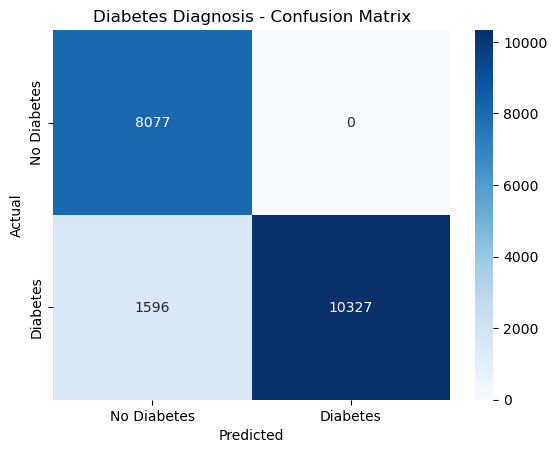

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [6]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

Same issue as with the other models... We will try to tune the Ada Boost model nonetheless. We will keep n_iter and cv parameters relatively low, since our expectations are not very high.

In [13]:
param_distributions = {
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1],
    'estimator__max_depth': [1, 2, 3],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5],
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2))

search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_distributions,
    n_iter=25,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=2025
)

search.fit(X_train, y_train)

n_estimators = search.best_params_['n_estimators']
learning_rate = search.best_params_['learning_rate']
max_depth = search.best_params_['estimator__max_depth']
min_samples_split = search.best_params_['estimator__min_samples_split']
min_samples_leaf = search.best_params_['estimator__min_samples_leaf']

search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


{'n_estimators': 50,
 'learning_rate': 0.3,
 'estimator__min_samples_split': 10,
 'estimator__min_samples_leaf': 2,
 'estimator__max_depth': 2}

In [14]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    ),
    n_estimators=n_estimators,
    learning_rate=learning_rate
)

ada.fit(X_train, y_train)

,estimator,DecisionTreeC...ples_split=10)
,n_estimators,50
,learning_rate,0.3
,algorithm,'deprecated'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,10
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0


In [15]:
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

Training Set Metrics:


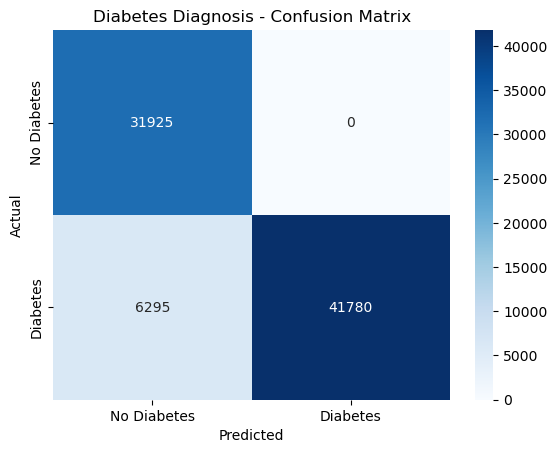

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics:


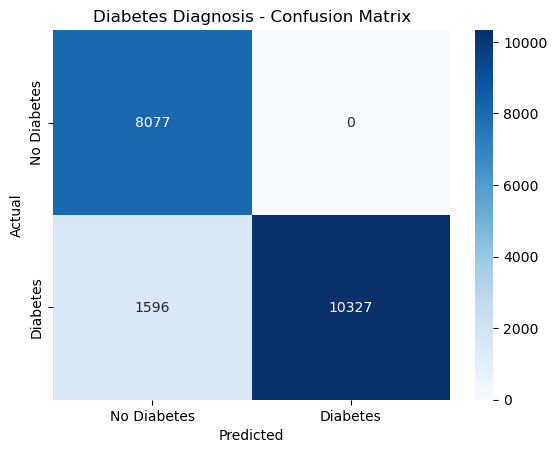

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [16]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

It looks like Ada Boost is dealing with the same issue as the other models.

In [17]:
y_train_probs = ada.predict_proba(X_train)[:, 1]
y_test_probs = ada.predict_proba(X_test)[:, 1]

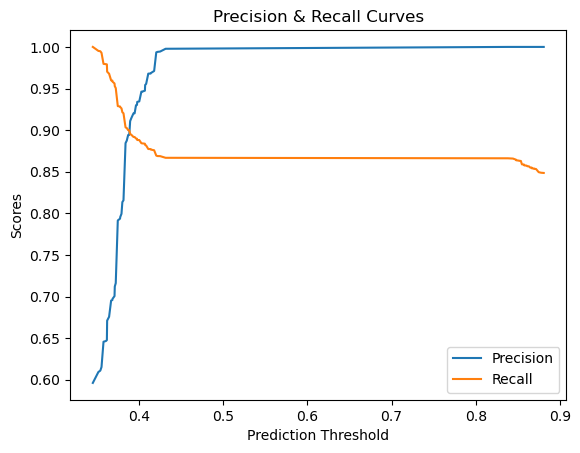

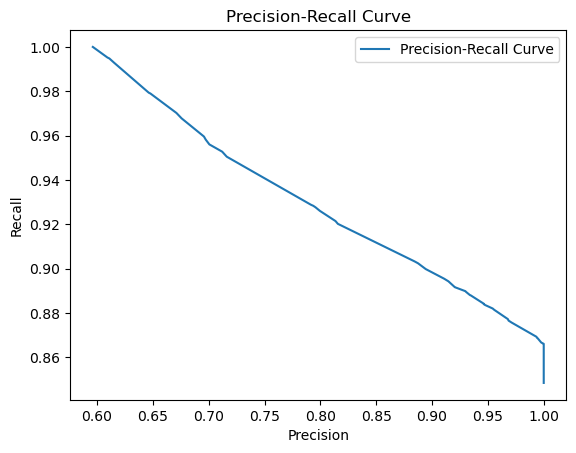

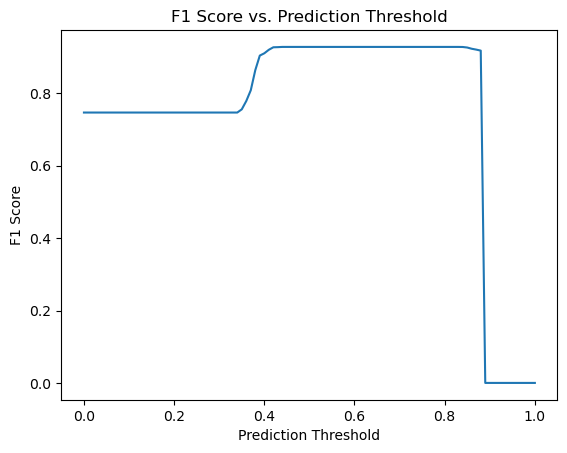

np.float64(0.44)

In [18]:
thresh = optimize_threshold(y_test, y_test_probs)
thresh

In [19]:
preds_train = y_train_probs >= thresh
preds_test = y_test_probs >= thresh

Training Set Metrics with Optimized Threshold:


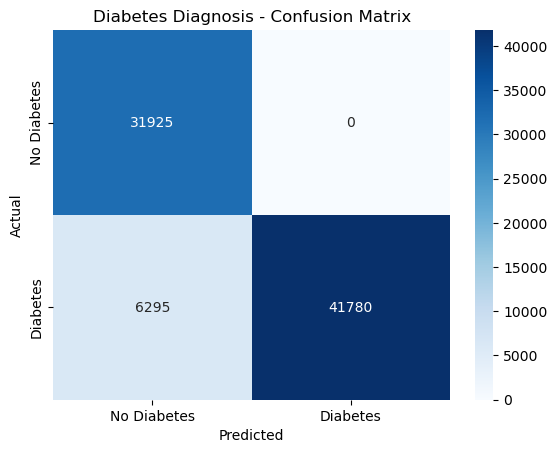

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics with Optimized Threshold:


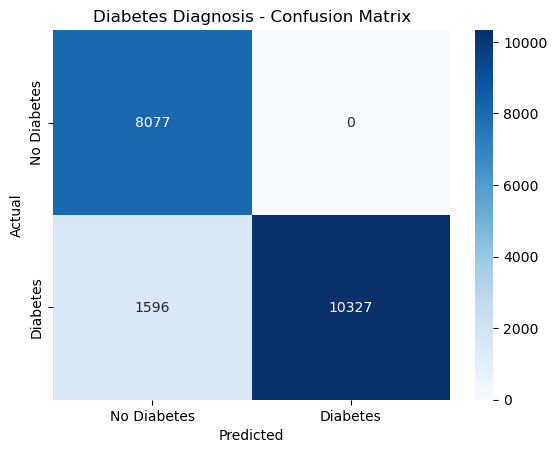

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [20]:
evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

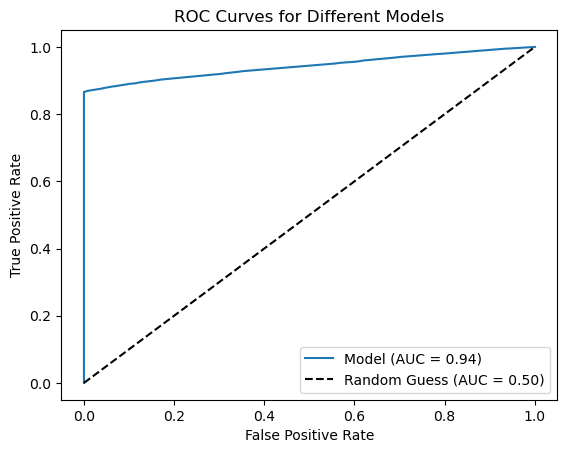

In [21]:
plot_roc_curve(y_test, y_test_probs)

This model performed exactly the same as GBM.

In [22]:
joblib.dump(ada, "../models/ada_boost_model.joblib")

['../models/ada_boost_model.joblib']